# Capstone Project
## Definition
### Project Overview
My project is my code for the [Kaggle Shelter Animal Outcomes contest](https://www.kaggle.com/c/shelter-animal-outcomes).  As described on Kaggle:
>Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.

### Problem Statement
As described on Kaggle:
>Using a dataset of intake information including breed, color, sex, and age from the 
> [Austin Animal Center](http://www.austintexas.gov/department/animal-services), 
> we're asking Kagglers to predict the outcome for each animal.

### Metrics
As described on Kaggle:
> <p>Submissions are evaluated using the <a href="https://www.kaggle.com/wiki/MultiClassLogLoss">multi-class logarithmic loss</a>. Each incident has been labeled with one true class. For each animal, you must submit a set of predicted probabilities (one for every class). The formula is then,</p>
> <p>$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$$</p>
> <p>where N is the number of animals in the test set, M is the number of outcomes, \\(log\\) is the natural logarithm, \\(y_{ij}\\) is 1 if observation \\(i\\) is in outcome \\(j\\) and 0 otherwise, and $p_{ij}$ is the predicted probability that observation \\(i\\) belongs to outcome \\(j\\).</p>
> <p>The submitted probabilities for a given animal are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).</p>


## Analysis
### Data Exploration

In [100]:
%matplotlib inline
import pandas as pd 

train_data = pd.read_csv('../data/train.csv', parse_dates=['DateTime'])
train_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [101]:
train_data.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [102]:
test_data = pd.read_csv('../data/test.csv', parse_dates=['DateTime'])
test_data.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

From the data info, we can see that many of the animals have missing names.  This should not matter since it is unlikely that an animal's outcome would depend on its name.  (However, we will find out later that whether the animal is named has an effect on its outcome.)  The many missing OutcomeSubtype values should also not matter since we are only trying to predict the OutcomeType.  Finally, there is only one missing value for SexuponOutcome and 18 missing values for AgeuponOutcome.  We use the mean age for missing AgeuponOutcome values.

### Exploratory Visualization

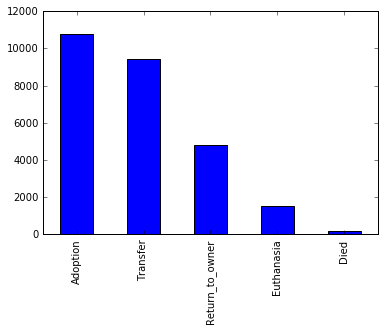

In [28]:
import numpy as np
import matplotlib.pyplot as plt

value_counts = data['OutcomeType'].value_counts()
value_counts.plot(kind='bar')

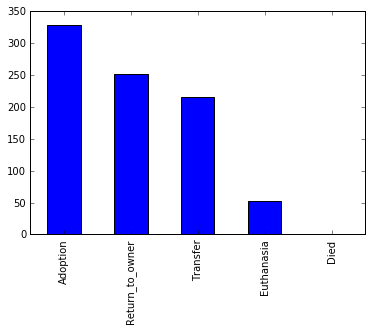

In [7]:
dog = data['AnimalType'] == "Dog"
black = data['Color'] == "Black"
black_dogs = data[black & dog]
black_dogs['OutcomeType'].value_counts().plot(kind='bar')

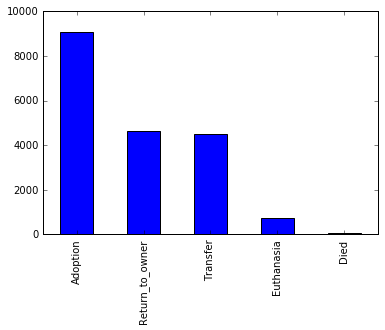

In [31]:
has_name = data['Name'].notnull()
named = data[has_name]
named['OutcomeType'].value_counts().plot(kind='bar')

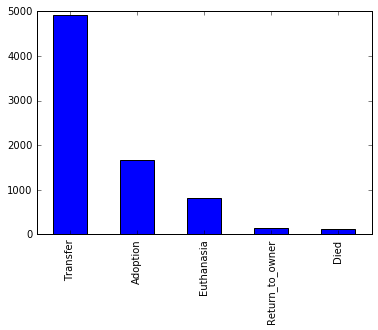

In [34]:
no_name = data['Name'].isnull()
un_named = data[no_name]
un_named['OutcomeType'].value_counts().plot(kind='bar')

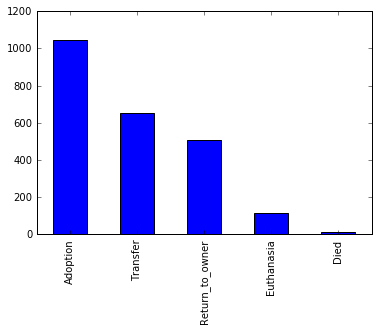

In [40]:
from util import get_month
data['Month'] = data['DateTime'].apply(get_month)
jan = data[data['Month'] == 1]
jan['OutcomeType'].value_counts().plot(kind='bar')

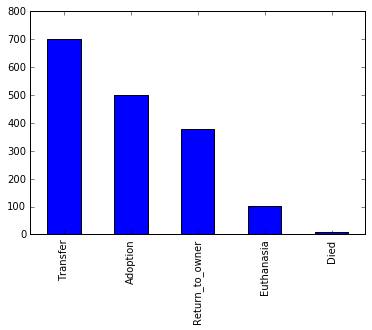

In [41]:
apr = data[data['Month'] == 4]
apr['OutcomeType'].value_counts().plot(kind='bar')

In [42]:
data['AnimalType'].unique()

array(['Dog', 'Cat'], dtype=object)

In [43]:
data['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [44]:
data['AgeuponOutcome'].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [88]:
data['Breed'].unique()
'Old English Sheepdog' in data['Breed'].unique()

True

In [46]:
len(data['Breed'].unique())

1380

In [47]:
data['Color'].unique()

array(['Brown/White', 'Cream Tabby', 'Blue/White', 'Blue Cream', 'Tan',
       'Black/Tan', 'Blue Tabby', 'Brown Tabby', 'Red/White', 'White',
       'Black', 'Silver', 'Brown', 'Black/Red', 'White/Cream',
       'Orange Tabby/White', 'Black/White', 'Brown Brindle/White',
       'Black/Brown', 'Orange Tabby', 'Chocolate/White', 'White/Tan',
       'Cream Tabby/White', 'Blue', 'Calico', 'Torbie', 'Brown/Black',
       'Yellow', 'Tricolor', 'White/Black', 'Tortie', 'Blue Tabby/White',
       'Gray/White', 'Tan/Black', 'Tan/White', 'Buff', 'Brown Tabby/White',
       'Red', 'Blue/Tan', 'Seal Point', 'Brown Brindle', 'White/Brown',
       'Gray', 'Yellow Brindle/White', 'Fawn/White', 'Flame Point',
       'Black Tabby/White', 'Tortie/Calico', 'Black/Brown Brindle',
       'White/Gray', 'Tan/Silver', 'Red Tick/Black', 'White/Cream Tabby',
       'Blue Merle', 'Chocolate/Tan', 'Sable', 'Brown Merle/White',
       'Brown Tiger/White', 'Liver/White', 'White/Blue Tabby',
       'Black/Gray', 'C

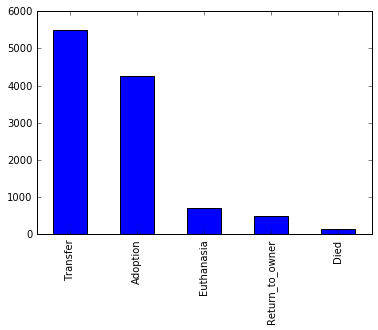

In [90]:
cats = data[data['AnimalType'] == "Cat"]
cats['OutcomeType'].value_counts().plot(kind='bar')

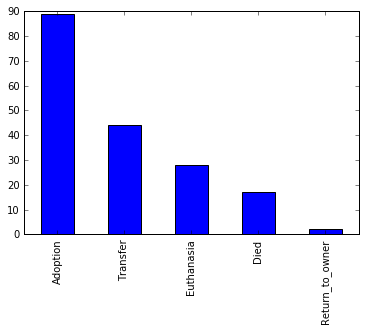

In [94]:
def get_hour(date_time):
    return date_time.hour
hour = cats['DateTime'].apply(get_hour)
cats.loc[:, 'Hour'] = hour
cats_at_eight = cats[cats['Hour'] == 8]
cats_at_eight['OutcomeType'].value_counts().plot(kind='bar')

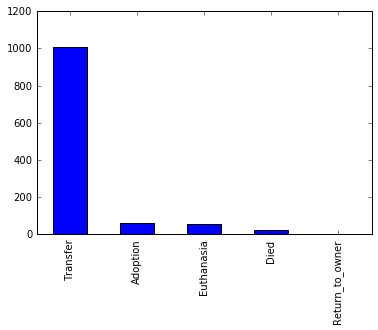

In [93]:
cats_at_nine = cats[cats['Hour'] == 9]
cats_at_nine['OutcomeType'].value_counts().plot(kind='bar')

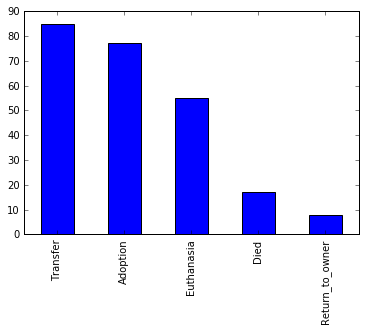

In [95]:
cats_at_ten = cats[cats['Hour'] == 10]
cats_at_ten['OutcomeType'].value_counts().plot(kind='bar')

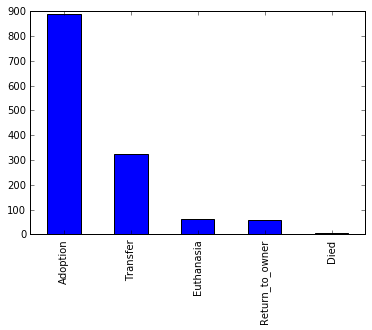

In [97]:
cats_at_five_pm = cats[cats['Hour'] == 17]
cats_at_five_pm['OutcomeType'].value_counts().plot(kind='bar')

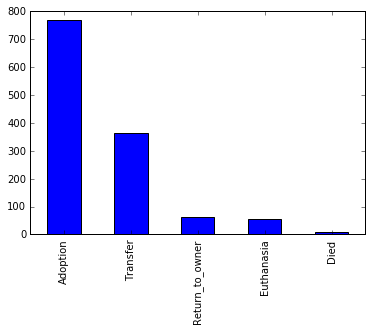

In [98]:
cats_at_six_pm = cats[cats['Hour'] == 18]
cats_at_six_pm['OutcomeType'].value_counts().plot(kind='bar')

### Algorithms and Techniques
I used a wide variety of classification algorithms.  I got this list of algorithms from [Classifier comparison]
(http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).  Here is the log-loss performance of the algorithms:

<table>
  <caption>Log-loss performance</caption>
  <tr>
    <th>Algorithm</th>
    <th>Cat</th> 
    <th>Dog</th>
  </tr>
  <tr>
    <td>Nearest Neighbors</td>
    <td>1.66271</td> 
    <td>1.29723</td>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>0.76244</td> 
    <td>1.16388</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.57658</td> 
    <td>0.95536</td>
  </tr>
  <tr>
    <td>AdaBoost</td>
    <td>1.52599</td> 
    <td>1.56269</td>
  </tr>
  <tr>
    <td>Naive Bayes</td>
    <td>1.95993</td> 
    <td>2.32285</td>
  </tr>
  <tr>
    <td>Linear Discriminant Analysis</td>
    <td>0.71434</td> 
    <td>1.00974</td>
  </tr>
  <tr>
    <td>Quadratic Discriminant Analysis</td>
    <td>1.78311</td> 
    <td>2.30627</td>
  </tr>
  <tr>
    <td>Linear SVM</td>
    <td>0.74214</td> 
    <td>1.02569</td>
  </tr>
  <tr>
    <td>RBF SVM</td>
    <td>0.67900</td> 
    <td>1.01030</td>
  </tr>
</table>

The code for generating these scores is in [scripts.classifier_comparison](https://github.com/paul-reiners/kaggle-shelter-animal-outcomes/blob/master/src/scripts/classifier_comparison.py).  As you can see, random forests performed best for both cats and dogs.

### Benchmark
## Methodology
## Results
## Conclusion